In [1]:
import os
import sys
import numpy as np
import keras
# from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
seed = 273
kinase = 'tpk_lck'

In [3]:
#import data
smiles_lines = [line.strip().split(',') for line in open(os.path.join('data', kinase+'_smiles.csv'))]
smiles = [line[1] for line in smiles_lines]
fingerprint_lines = [line.strip().split(',') for line in open(os.path.join('data', kinase+'_fingerprints.csv'))]
fingerprints = [line[2:] for line in fingerprint_lines]
X_fingerprints = np.asarray(fingerprints, dtype=np.int16)
y = np.asarray([int(line[2]) for line in smiles_lines], dtype=np.int8)

In [4]:
#pad smiles with '!' to ensure equal length
max_smiles_len = max(len(s) for s in smiles)
smiles = [s + '!'*(max_smiles_len + 1 - len(s)) for s in smiles]

In [5]:
#one-hot vector representation of smiles
char_set = set()
for s in smiles:
    for c in s:
        char_set.add(c)
char_set = list(char_set)
char_to_index = {char_set[i]: i for i in range(len(char_set))}

X_smiles = np.zeros((len(smiles), max_smiles_len + 1, len(char_set)))
for i in range(len(smiles)):
    code = smiles[i]
    for j in range(len(code)):
        char = code[j]
        X_smiles[i, j, char_to_index[char]] = 1        

In [6]:
print(X_fingerprints.shape)
print(X_smiles.shape)
print(y.shape)

(1809, 4096)
(1809, 268, 40)
(1809,)


In [7]:
#train val test split
n_tot = X_smiles.shape[0]
n_test = round(n_tot*0.15)
n_val = round(n_tot*0.15)
n_train  = n_tot - n_test - n_val
indices = np.arange(n_tot, dtype=int)
np.random.seed(seed)
np.random.shuffle(indices)
indices_train = indices[:n_train]
indices_val = indices[n_train:n_train+n_val]
indices_test = indices[n_train+n_val:]
X_fingerprints_train = X_fingerprints[indices_train]
print(X_fingerprints_train.shape)
X_smiles_train = X_smiles[indices_train]
print(X_smiles_train.shape)
y_train = y[indices_train]
print(y_train.shape)
X_fingerprints_val = X_fingerprints[indices_val]
print(X_fingerprints_val.shape)
X_smiles_val = X_smiles[indices_val]
print(X_smiles_val.shape)
y_val = y[indices_val]
print(y_val.shape)
X_fingerprints_test = X_fingerprints[indices_test]
print(X_fingerprints_test.shape)
X_smiles_test = X_smiles[indices_test]
print(X_smiles_test.shape)
y_test = y[indices_test]
print(y_test.shape)
smiles_input_shape = X_smiles_train.shape[1:]
fingerprints_input_shape = X_fingerprints_train.shape[1:]

(1267, 4096)
(1267, 268, 40)
(1267,)
(271, 4096)
(271, 268, 40)
(271,)
(271, 4096)
(271, 268, 40)
(271,)


In [8]:
#check GPU presence
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [9]:
#keras imports
from keras.models import Sequential
from keras.layers import TimeDistributed, GlobalAveragePooling2D, Activation, Dense, Input, Bidirectional
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, EarlyStopping
from keras.layers import Dropout, Flatten
from keras.layers import concatenate, average
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import metrics

In [10]:
#F1 score computation
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
npzfile = np.load('mlp_' + kinase + '.npz')
pred_train_mlp, pred_val_mlp, pred_test_mlp = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, pred_train_mlp)
auc_train = roc_auc_score(y_train, pred_train_mlp)
fpr_mlp_val, tpr_mlp_val, _ = roc_curve(y_val, pred_val_mlp)
auc_val = roc_auc_score(y_val, pred_val_mlp)
fpr_mlp_test, tpr_mlp_test, _ = roc_curve(y_test, pred_test_mlp)
auc_test = roc_auc_score(y_test, pred_test_mlp)
print('MLP Train AUC: %s' % auc_train)
print('MLP Val AUC: %s' % auc_val)
print('MLP Test AUC: %s' % auc_test)

MLP Train AUC: 0.973577123156955
MLP Val AUC: 0.9127210884353741
MLP Test AUC: 0.941938775510204


In [12]:
npzfile = np.load('rnn_' + kinase + '.npz')
pred_train_rnn, pred_val_rnn, pred_test_rnn = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_train, tpr_rnn_train, _ = roc_curve(y_train, pred_train_rnn)
auc_train = roc_auc_score(y_train, pred_train_rnn)
fpr_rnn_val, tpr_rnn_val, _ = roc_curve(y_val, pred_val_rnn)
auc_val = roc_auc_score(y_val, pred_val_rnn)
fpr_rnn_test, tpr_rnn_test, _ = roc_curve(y_test, pred_test_rnn)
auc_test = roc_auc_score(y_test, pred_test_rnn)
print('RNN Train AUC: %s' % auc_train)
print('RNN Val AUC: %s' % auc_val)
print('RNN Test AUC: %s' % auc_test)

RNN Train AUC: 0.9156185551143535
RNN Val AUC: 0.8600680272108844
RNN Test AUC: 0.8976190476190475


In [13]:
npzfile = np.load('rnn_mlp_early_' + kinase + '.npz')
pred_train_mlp_rnn_early, pred_val_mlp_rnn_early, pred_test_mlp_rnn_early = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_early_train, tpr_rnn_mlp_early_train, _ = roc_curve(y_train, pred_train_mlp_rnn_early)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_early)
fpr_rnn_mlp_early_val, tpr_rnn_mlp_early_val, _ = roc_curve(y_val, pred_val_mlp_rnn_early)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_early)
fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, _ = roc_curve(y_test, pred_test_mlp_rnn_early)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_early)
print('RNN+MLP Early Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Early Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Early Fusion Test AUC: %s' % auc_test)

RNN+MLP Early Fusion Train AUC: 0.9757349093483547
RNN+MLP Early Fusion Val AUC: 0.9119727891156463
RNN+MLP Early Fusion Test AUC: 0.9405442176870749


In [14]:
npzfile = np.load('rnn_mlp_late_' + kinase + '.npz')
pred_train_mlp_rnn_late, pred_val_mlp_rnn_late, pred_test_mlp_rnn_late = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_late_train, tpr_rnn_mlp_late_train, _ = roc_curve(y_train, pred_train_mlp_rnn_late)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_late)
fpr_rnn_mlp_late_val, tpr_rnn_mlp_late_val, _ = roc_curve(y_val, pred_val_mlp_rnn_late)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_late)
fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, _ = roc_curve(y_test, pred_test_mlp_rnn_late)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_late)
print('RNN+MLP Late Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Late Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Late Fusion Test AUC: %s' % auc_test)

RNN+MLP Late Fusion Train AUC: 0.9648320866808262
RNN+MLP Late Fusion Val AUC: 0.9137414965986396
RNN+MLP Late Fusion Test AUC: 0.9287755102040817


In [15]:
pred_train_mlp_rnn_ens = (pred_train_mlp + pred_train_rnn)/2.
pred_val_mlp_rnn_ens = (pred_val_mlp + pred_val_rnn)/2.
pred_test_mlp_rnn_ens = (pred_test_mlp + pred_test_rnn)/2.
fpr_rnn_mlp_ens_train, tpr_rnn_mlp_ens_train, _ = roc_curve(y_train, pred_train_mlp_rnn_ens)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_ens)
fpr_rnn_mlp_ens_val, tpr_rnn_mlp_ens_val, _ = roc_curve(y_val, pred_val_mlp_rnn_ens)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_ens)
fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, _ = roc_curve(y_test, pred_test_mlp_rnn_ens)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_ens)
print('RNN+MLP Ensemble Train AUC: %s' % auc_train)
print('RNN+MLP Ensemble Val AUC: %s' % auc_val)
print('RNN+MLP Ensemble Test AUC: %s' % auc_test)

RNN+MLP Ensemble Train AUC: 0.9687136393018746
RNN+MLP Ensemble Val AUC: 0.8998639455782314
RNN+MLP Ensemble Test AUC: 0.945374149659864


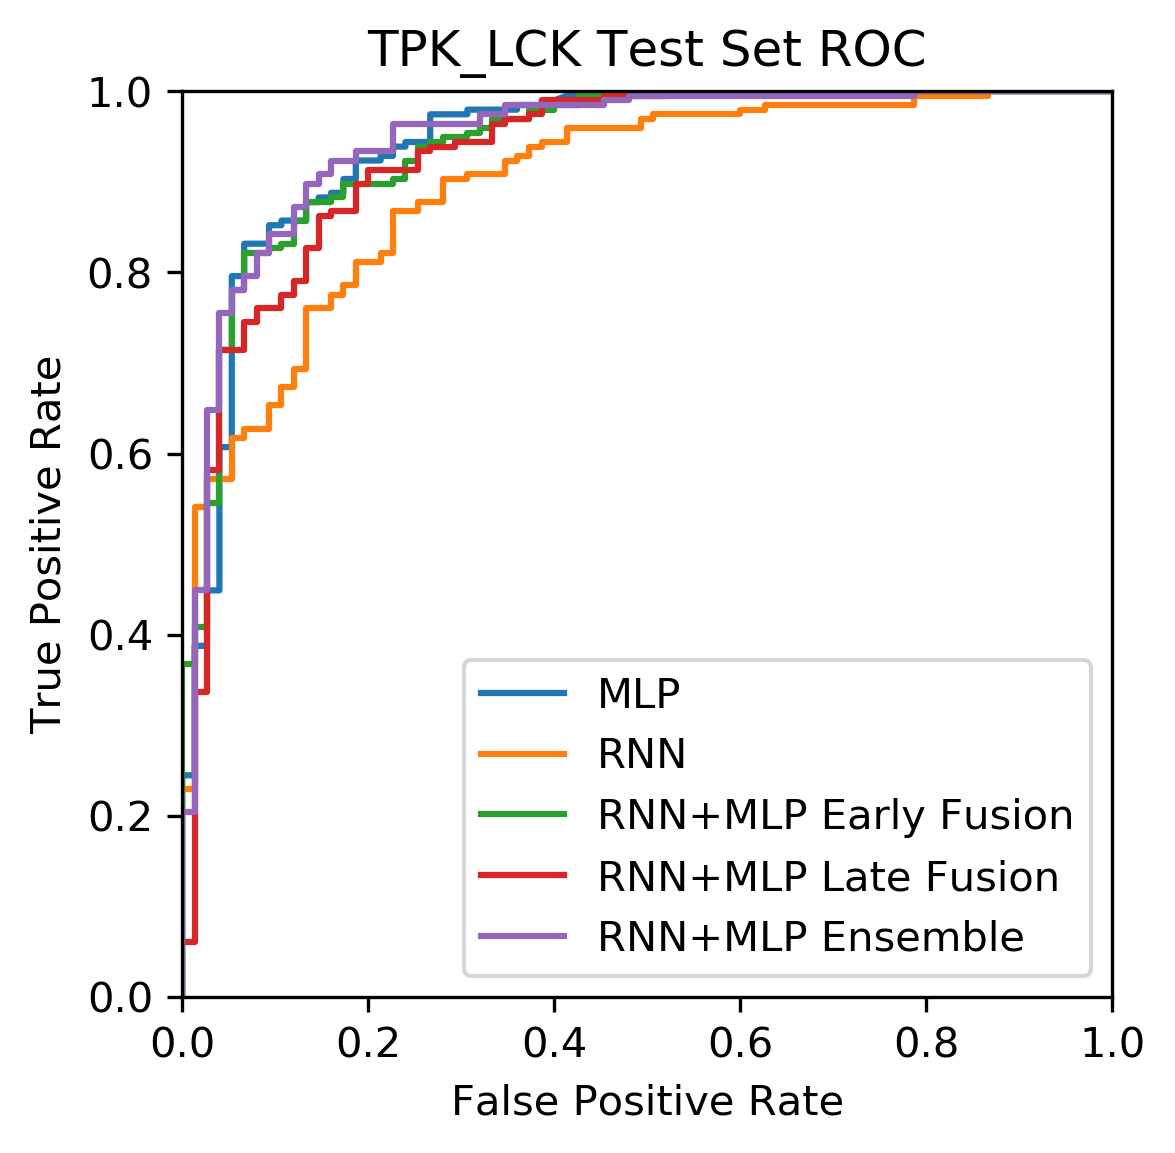

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(4,4), dpi=300)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s Test Set ROC' % kinase.upper())
plt.xlim(0,1)
plt.ylim(0,1)
plt_mlp, = plt.plot(fpr_mlp_test, tpr_mlp_test, label='MLP')
plt_rnn, = plt.plot(fpr_rnn_test, tpr_rnn_test, label='RNN')
plt_rnn_mlp_early, = plt.plot(fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, label='RNN+MLP Early Fusion')
plt_rnn_mlp_late, = plt.plot(fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, label='RNN+MLP Late Fusion')
plt_rnn_mlp_ens, = plt.plot(fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, label='RNN+MLP Ensemble')
plt.legend(handles=[plt_mlp, plt_rnn, plt_rnn_mlp_early, plt_rnn_mlp_late, plt_rnn_mlp_ens])
fig1.savefig(os.path.join('curves', kinase + '_ROC_old.png'), bbox_inches='tight')
plt.show()

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
p_mlp_train, r_mlp_train, _ = precision_recall_curve(y_train, pred_train_mlp)
aps_train = average_precision_score(y_train, pred_train_mlp)
p_mlp_val, r_mlp_val, _ = precision_recall_curve(y_val, pred_val_mlp)
aps_val = average_precision_score(y_val, pred_val_mlp)
p_mlp_test, r_mlp_test, _ = precision_recall_curve(y_test, pred_test_mlp)
aps_test = average_precision_score(y_test, pred_test_mlp)
print('MLP Train APS: %s' % aps_train)
print('MLP Val APS: %s' % aps_val)
print('MLP Test APS: %s' % aps_test)

MLP Train APS: 0.986849764154672
MLP Val APS: 0.9644157531703279
MLP Test APS: 0.9720545822899445


In [18]:
p_rnn_train, r_rnn_train, _ = precision_recall_curve(y_train, pred_train_rnn)
aps_train = average_precision_score(y_train, pred_train_rnn)
p_rnn_val, r_rnn_val, _ = precision_recall_curve(y_val, pred_val_rnn)
aps_val = average_precision_score(y_val, pred_val_rnn)
p_rnn_test, r_rnn_test, _ = precision_recall_curve(y_test, pred_test_rnn)
aps_test = average_precision_score(y_test, pred_test_rnn)
print('RNN Train APS: %s' % aps_train)
print('RNN Val APS: %s' % aps_val)
print('RNN Test APS: %s' % aps_test)

RNN Train APS: 0.9623130863229994
RNN Val APS: 0.9354269090988001
RNN Test APS: 0.9566413830570607


In [19]:
p_mlp_rnn_early_train, r_mlp_rnn_early_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_early)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_early)
p_mlp_rnn_early_val, r_mlp_rnn_early_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_early)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_early)
p_mlp_rnn_early_test, r_mlp_rnn_early_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_early)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_early)
print('RNN+MLP Early Fusion Train APS: %s' % aps_train)
print('RNN+MLP Early Fusion Val APS: %s' % aps_val)
print('RNN+MLP Early Fusion Test APS: %s' % aps_test)

RNN+MLP Early Fusion Train APS: 0.9898158388810585
RNN+MLP Early Fusion Val APS: 0.9614014468353445
RNN+MLP Early Fusion Test APS: 0.9739785155871039


In [20]:
p_mlp_rnn_late_train, r_mlp_rnn_late_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_late)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_late)
p_mlp_rnn_late_val, r_mlp_rnn_late_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_late)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_late)
p_mlp_rnn_late_test, r_mlp_rnn_late_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_late)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_late)
print('RNN+MLP Late Fusion Train APS: %s' % aps_train)
print('RNN+MLP Late Fusion Val APS: %s' % aps_val)
print('RNN+MLP Late Fusion Test APS: %s' % aps_test)

RNN+MLP Late Fusion Train APS: 0.9848285742402206
RNN+MLP Late Fusion Val APS: 0.9650283174217347
RNN+MLP Late Fusion Test APS: 0.9616757519144321


In [21]:
p_mlp_rnn_ens_train, r_mlp_rnn_ens_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_ens)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_ens)
p_mlp_rnn_ens_val, r_mlp_rnn_ens_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_ens)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_ens)
p_mlp_rnn_ens_test, r_mlp_rnn_ens_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_ens)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_ens)
print('RNN+MLP Ensemble Fusion Train APS: %s' % aps_train)
print('RNN+MLP Ensemble Fusion Val APS: %s' % aps_val)
print('RNN+MLP Ensemble Fusion Test APS: %s' % aps_test)

RNN+MLP Ensemble Fusion Train APS: 0.9859463527416981
RNN+MLP Ensemble Fusion Val APS: 0.9543944762284122
RNN+MLP Ensemble Fusion Test APS: 0.9743685616728064


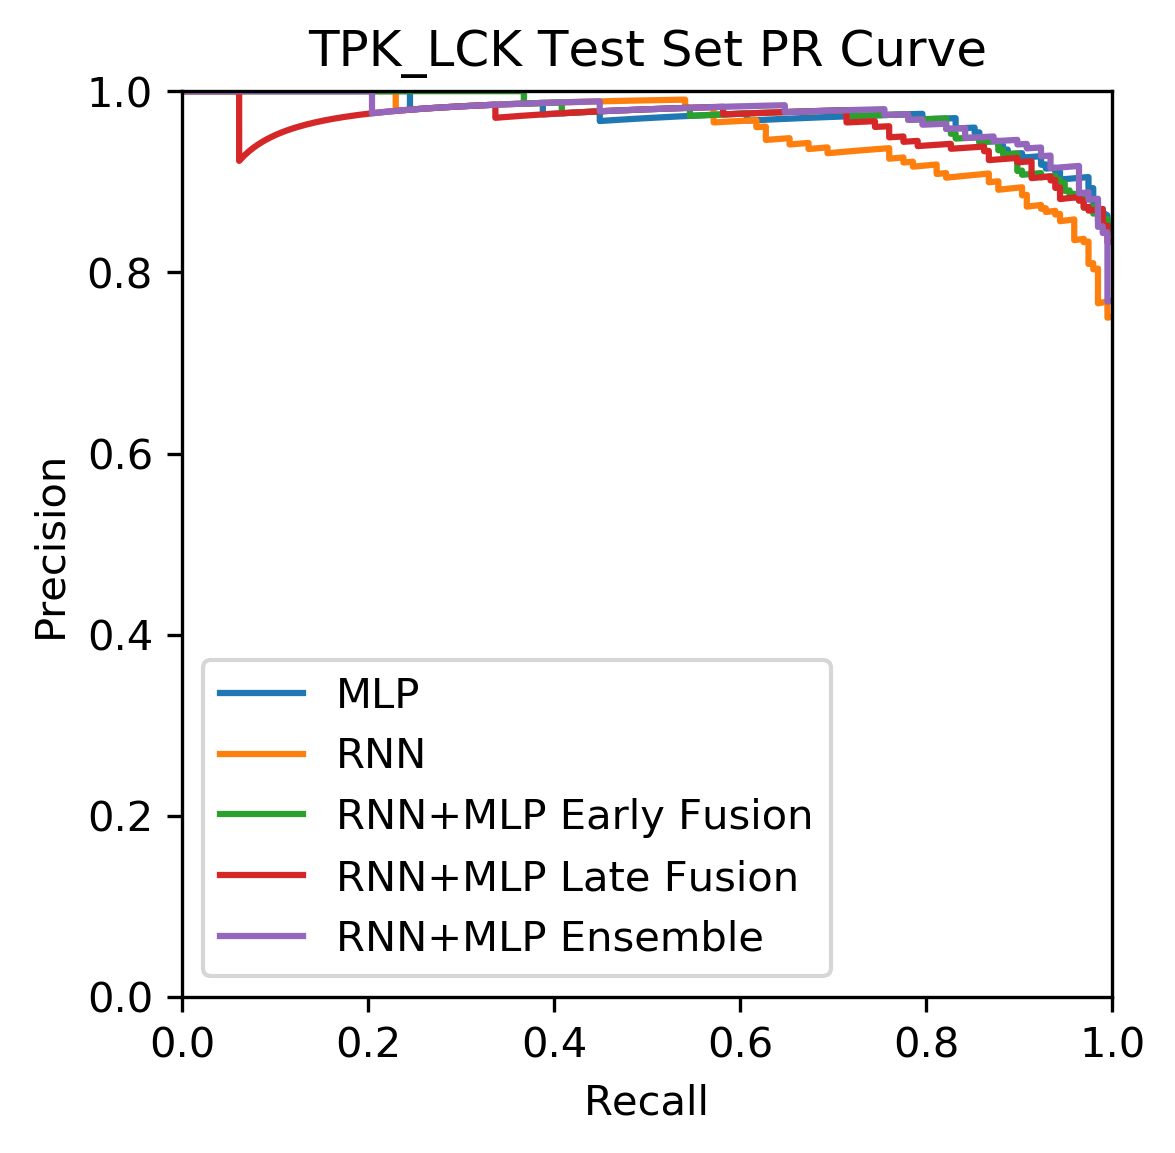

In [22]:
%matplotlib inline
fig2 = plt.figure(figsize=(4,4), dpi=300)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('%s Test Set PR Curve' % kinase.upper())
plt.xlim(0,1)
plt.ylim(0,1)
plt_mlp, = plt.plot(r_mlp_test, p_mlp_test, label='MLP')
plt_rnn, = plt.plot(r_rnn_test, p_rnn_test, label='RNN')
plt_rnn_mlp_early, = plt.plot(r_mlp_rnn_early_test, p_mlp_rnn_early_test, label='RNN+MLP Early Fusion')
plt_rnn_mlp_late, = plt.plot(r_mlp_rnn_late_test, p_mlp_rnn_late_test, label='RNN+MLP Late Fusion')
plt_rnn_mlp_ens, = plt.plot(r_mlp_rnn_ens_test, p_mlp_rnn_ens_test, label='RNN+MLP Ensemble')
plt.legend(handles=[plt_mlp, plt_rnn, plt_rnn_mlp_early, plt_rnn_mlp_late, plt_rnn_mlp_ens])
fig2.savefig(os.path.join('curves', kinase + '_PR_old.png'), bbox_inches='tight')
plt.show()